<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Overnight_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1123]:
#!pip3 install pyfolio
import pyfolio as pyf

** OVERNIGHT TRADING STRATEGY**

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [1124]:
# For data manupulations

START = '2021-08-03'
END = '2023-08-04'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = True
LEFT, RIGHT = datetime.date(2021, 8, 3), datetime.date(2023, 8, 4)

# VF    LB    PEAK_CUM  CUM_LAST    REVERSED
# 0.25  45    6.11       4.29 OK    True
# 0.35  45    7.42       5.02 OK    True
# 0.40  45    7.64       5.17 OK    True
# 0.45  45    8.99       6.16 OK    True
# 0.45  45    1.22       1.05 OK    False
# 0.45  55    7.97       5.39 OK    True
# 0.45  40    9.35       6.31 OK    True
# 0.45  35    9.65       7.14 OK    True
# 0.45  33    9.78       7.24 OK    True  ***
# 0.45  32    10.02      7.42 OK    True  ****
# 0.45  30    9.16       6.78 OK    True
# 0.45  25    8.19       5.98 OK    True
# -   -       5.17       4.82 OK    True / original Gap up buy side.

import pandas as pd
import numpy as np
import yfinance as yf

# For plotting
import matplotlib.pyplot as plt

Ticker = "GARAN"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
#      Feasibility
# EREGL 2.26
# ASELS 1.53
# THYAO 0.34
# GARAN

# Read data from Yahoo finance
TickerIS = Ticker + ".IS"
data = yf.download(TickerIS,START, END)

data_close = data['Adj Close']

data_rel = data['Adj Close'] / data['Adj Close'][0]

# Convert index into datetime format
data.index = pd.to_datetime(data.index,format="%d-%m-%Y")

# Calculate adjustment factor
adjusted_factor = data['Adj Close'] / data['Close']

# Calculate adjusted open price
data['Adj Open'] = adjusted_factor * data['Open']

data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Open
Date,,,,,,,
2023-07-28,229.199997,237.600006,228.399994,235.000000,235.000000,52651752,229.199997
2023-07-31,235.800003,236.600006,232.600006,234.300003,234.300003,39359023,235.800003
2023-08-01,232.399994,235.100006,230.699997,231.000000,231.000000,28560161,232.399994
2023-08-02,231.000000,239.100006,230.300003,236.500000,236.500000,39485338,231.000000
2023-08-03,237.000000,238.399994,234.000000,234.600006,234.600006,24711720,237.000000


In [1125]:
# Calculate returns
data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

In [1126]:
# Calculate standard deviation of returns
data['std'] = data['returns'].rolling(R_WINDOW).std()

In [1127]:
data['positions'] = np.nan

In [1128]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [1129]:
# IMPROVED STRATEGY

# Long entry condition
if REVERSED:
  long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
else:
# Short entry condition
  long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']


In [1130]:
# Store 1 when long entry condition is true
data.loc[long_entry, 'positions'] = 1

# Store -1 when short entry condition is true
#data.loc[short_entry, 'positions'] = -1

# Store 0 when wait condition is true
data.loc[short_entry, 'positions'] = 0

data['positions'].fillna(method='ffill', inplace=True)

# Drop NaN values
#data = data.dropna()

In [1131]:
data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions

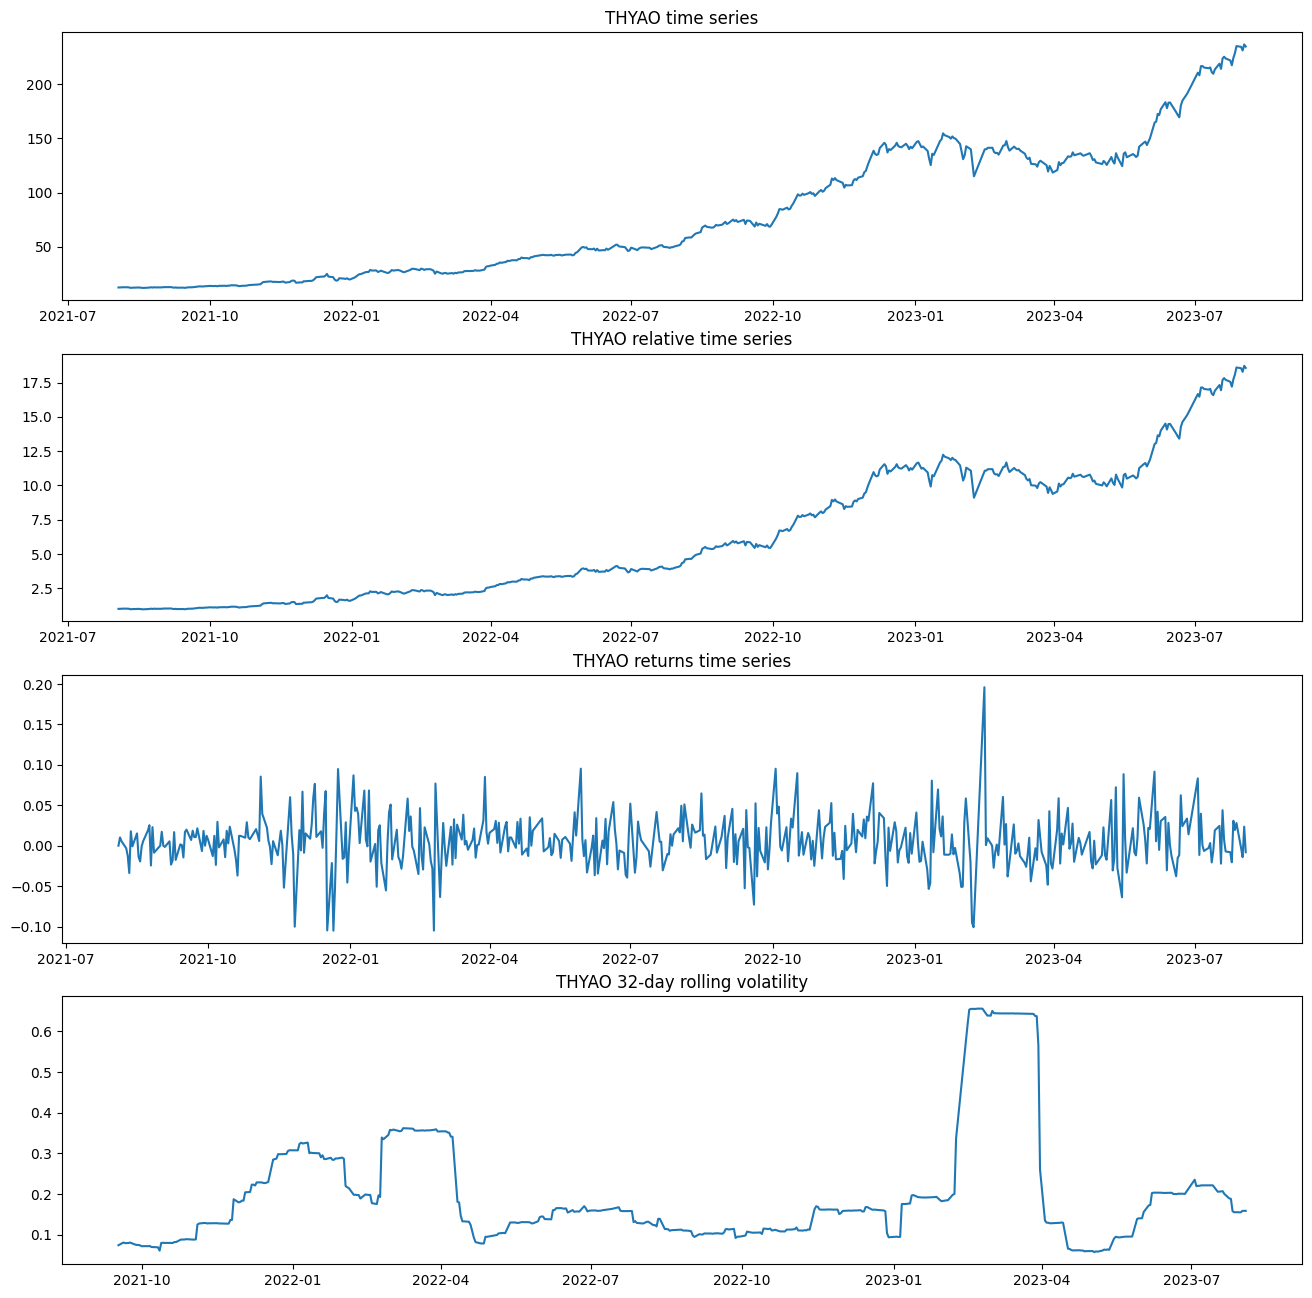

In [1132]:
plt.subplot(4, 1, 1)
plt.plot(data_close)
plt.title(f"{Ticker} time series")

plt.subplot(4, 1, 2)
plt.plot(data_rel)
plt.title(f"{Ticker} relative time series")

data_log_returns = data_close.pct_change().apply(lambda x: np.log(1+x))

plt.subplot(4, 1, 3)
plt.plot(data_log_returns)
plt.title(f"{Ticker} returns time series")

plt.subplot(4, 1, 4)
data_vlt = data_close.rolling(R_WINDOW).std()*(252**0.5)

plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.plot(data['std']*252**0.5)

fig = plt.gcf()
fig.set_size_inches(16, 16)
plt.show()

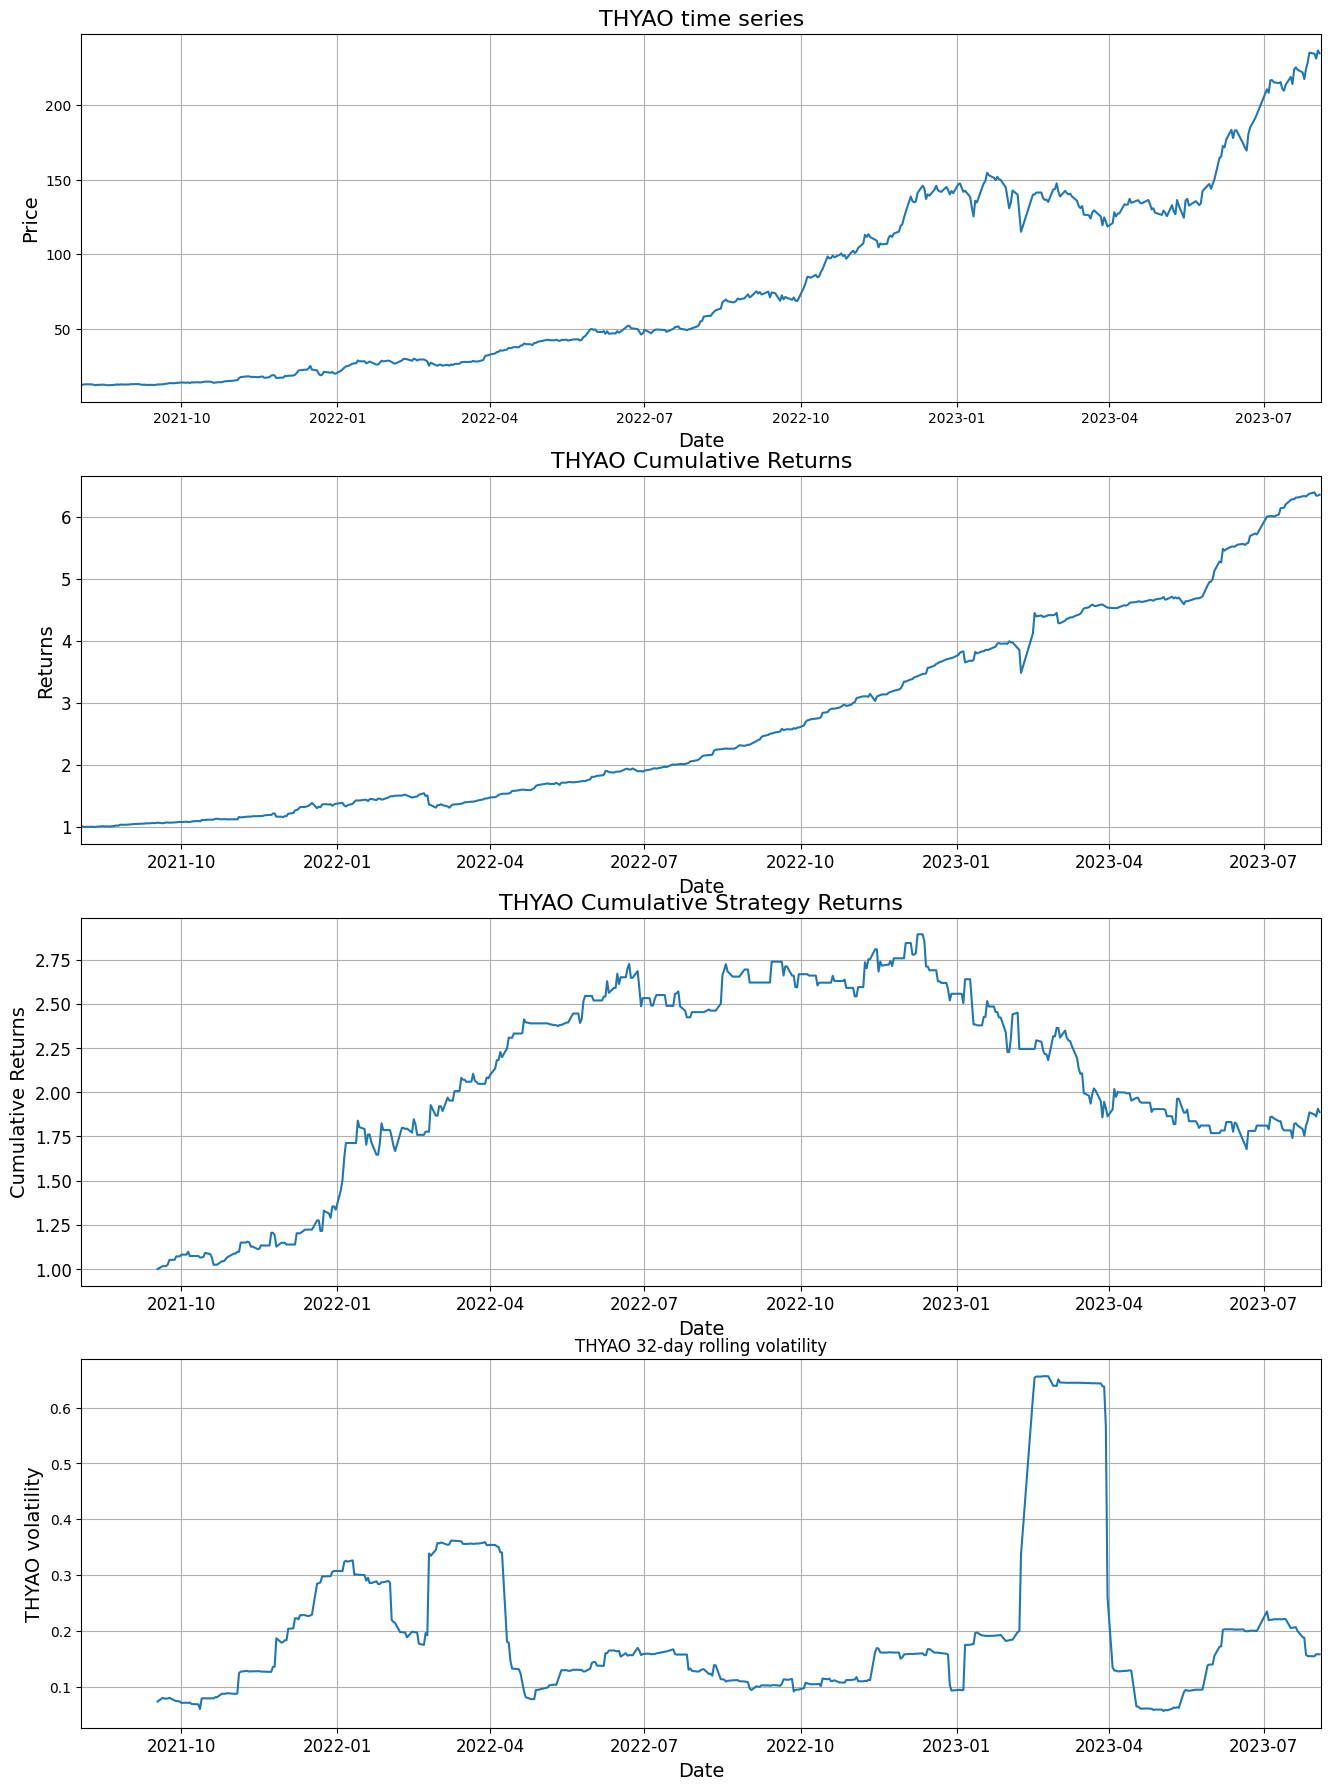

In [1133]:
# Plot cumulative returns

import datetime

plt.figure(figsize=(14,11))

plt.subplot(4, 1, 1)
plt.xlim(LEFT, RIGHT)
plt.plot(data_close)
plt.title(f"{Ticker} time series", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid()

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 2)
plt.xlim(LEFT, RIGHT)
data['cumulative_normal_returns'] = (data.returns+1).cumprod()

plt.plot(data.cumulative_normal_returns)
plt.title(f"{Ticker} normal returns")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 3)
plt.xlim(LEFT, RIGHT)
data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()


plt.plot(data.cumulative_strategy_returns)
plt.title(f"{Ticker} returns time series")
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cumulative strategy returns
# Define the label for the title of the figure
plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# ----------------------------------------------------------------------------------
plt.subplot(4, 1, 4)
plt.xlim(LEFT, RIGHT)
plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
plt.xlabel('Date', fontsize=14)
plt.ylabel(f'{Ticker} volatility', fontsize=14)
plt.grid()
plt.xticks(fontsize=12)

plt.plot(data['std']*252**0.5)
fig = plt.gcf()
fig.set_size_inches(16, 22)


plt.show()

In [1134]:
data.loc['2022-11-01':'2023-12-30']

,Open,High,Low,Close,Adj Close,Volume,Adj Open,returns,std,positions,strategy_returns,cumulative_normal_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,
2022-11-01,102.300003,104.800003,101.099998,102.400002,102.400002,62304734,102.300003,0.009872,0.007127,0.0,0.000000,3.000642,2.590052
2022-11-02,102.699997,102.800003,100.400002,100.800003,100.800003,59575517,102.699997,0.002930,0.007140,1.0,-0.018500,3.009432,2.542135
2022-11-03,103.000000,104.500000,101.000000,101.800003,101.800003,104108273,103.000000,0.021825,0.007415,0.0,-0.000000,3.075114,2.542135
2022-11-04,102.099998,106.400002,101.800003,104.199997,104.199997,112457958,102.099998,0.002947,0.006949,1.0,0.020568,3.084176,2.594422
2022-11-07,104.900002,107.599998,102.800003,107.199997,107.199997,108494047,104.900002,0.006718,0.006929,0.0,0.000000,3.104896,2.594422
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28,229.199997,237.600006,228.399994,235.000000,235.000000,52651752,229.199997,0.003063,0.009776,1.0,0.025305,6.371808,1.885942
2023-07-31,235.800003,236.600006,232.600006,234.300003,234.300003,39359023,235.800003,0.003404,0.009762,1.0,-0.006361,6.393500,1.873945
2023-08-01,232.399994,235.100006,230.699997,231.000000,231.000000,28560161,232.399994,-0.008109,0.009989,1.0,-0.006024,6.341653,1.862656


/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2021-09-17
End date,2023-08-03
Total months,22
,Backtest
Annual return,40.5%
Cumulative returns,88.8%
Annual volatility,34.2%
Sharpe ratio,1.16
Calmar ratio,0.96
Stability,0.25
Max drawdown,-42.0%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


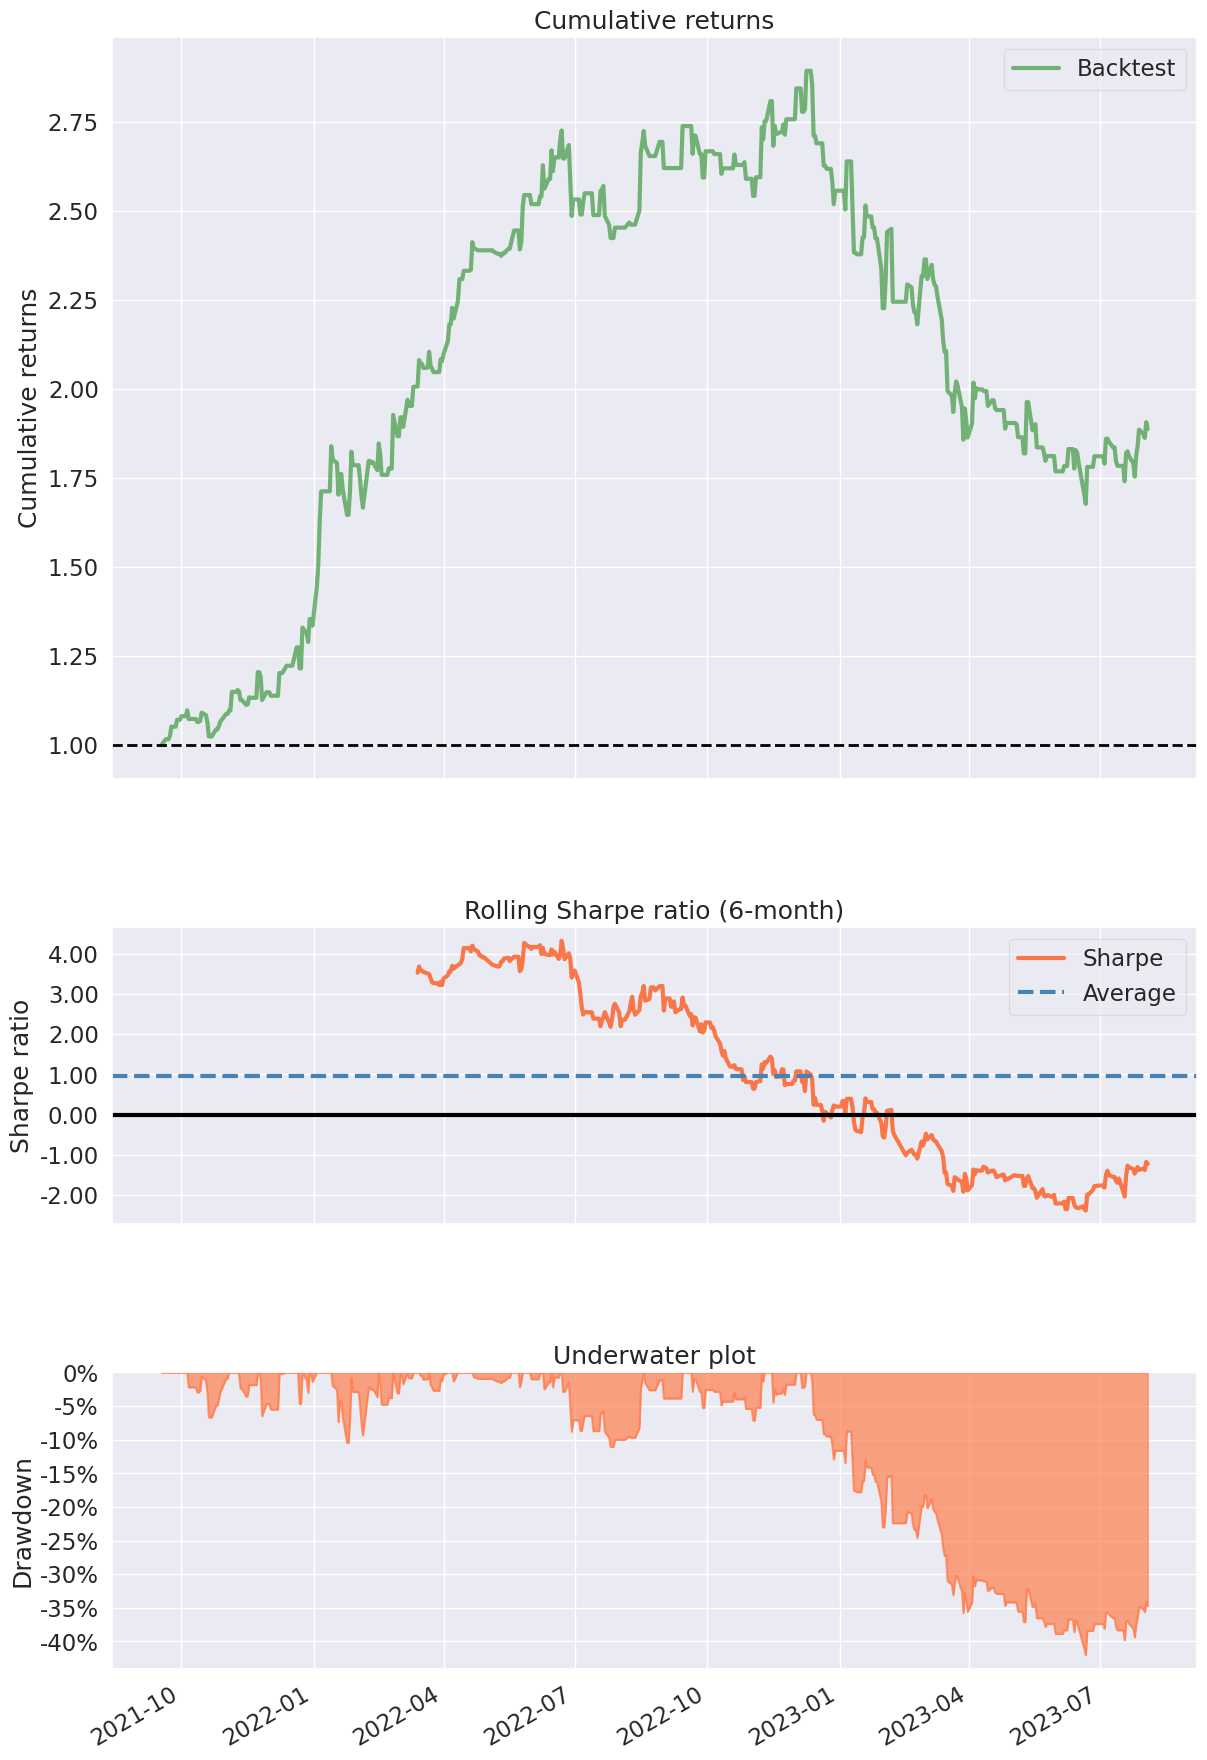

In [1135]:
pyf.create_simple_tear_sheet(data.strategy_returns.dropna())

In [1136]:
np.max(data.cumulative_normal_returns)

6.39349966901803

In [1137]:
(data.cumulative_normal_returns[-1])

6.355060158229317

In [1138]:
np.max(data.cumulative_strategy_returns)

2.893073598459048

In [1139]:
(data.cumulative_strategy_returns[-1])

1.8876934916070855

In [1140]:
data_rel[-1]

18.574822167679805

In [1141]:
data.cumulative_normal_returns[-1]

6.355060158229317

In [1142]:
feasible = data.cumulative_normal_returns[-1] / data_rel[-1]

In [1143]:
feasible

0.3421330282928427